<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/OCT_Landsat_ANN_simple_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8 y 5

* Se usa Keras 2.13 y tensorflow 2.13, para esto se desinstala la actual version 3 - por corregir
* Version con re-entrenamiento del modelo pre-entrenado
* Versión con la estandarizaciíón de datos con StandardScaler
* Version con un post-entranemiento del modelo pre-entrenado
* Clasificación en tres clases (no-urbano, urbano, agua)

In [1]:
!pip uninstall tensorflow
!pip3 install tensorflow==2.13

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  Fi

In [1]:


!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [2]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [43]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/OCT_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/OCT_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/OCT_2020_feature_L8_6b.npy')
array_feature_2011 = np.load('/content/drive/MyDrive/Colab Data/OCT_2011_feature_L5_6b.npy')
array_feature_2010 = np.load('/content/drive/MyDrive/Colab Data/OCT_2010_feature_L5_6b.npy')
array_feature_2000 = np.load('/content/drive/MyDrive/Colab Data/OCT_2000_feature_L5_6b.npy')
array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/OCT_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/OCT_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [5]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [44]:
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2020 = feature_transform(array_feature_2020)
x_features_2011 = feature_transform(array_feature_2011)
x_features_2010 = feature_transform(array_feature_2010)
x_features_2000 = feature_transform(array_feature_2000)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 467, 323)
(150841, 6)
(6, 467, 323)
(150841, 6)
(6, 467, 323)
(150841, 6)
(6, 467, 323)
(150841, 6)
(6, 467, 323)
(150841, 6)
(6, 467, 323)
(150841, 6)
(1, 467, 323)
(150841, 1)
(1, 467, 323)
(150841, 1)


Estandarización de datos

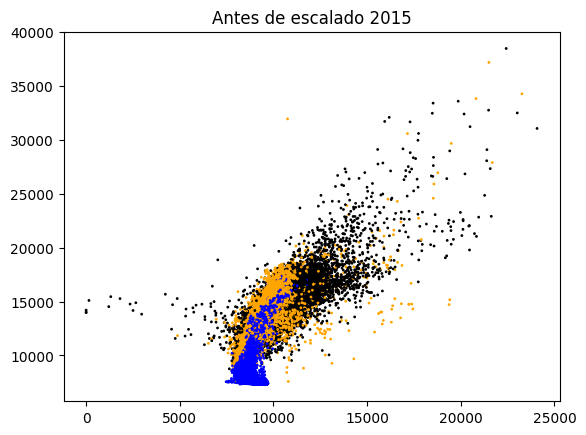

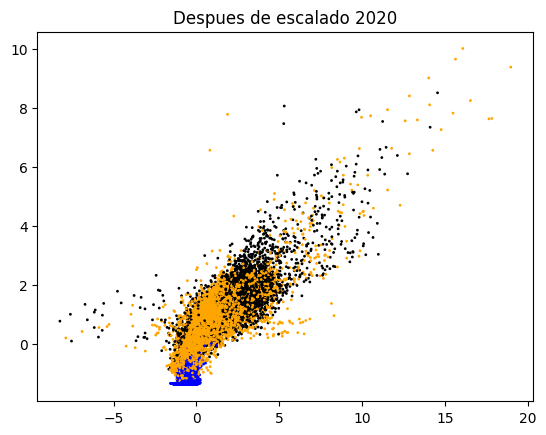

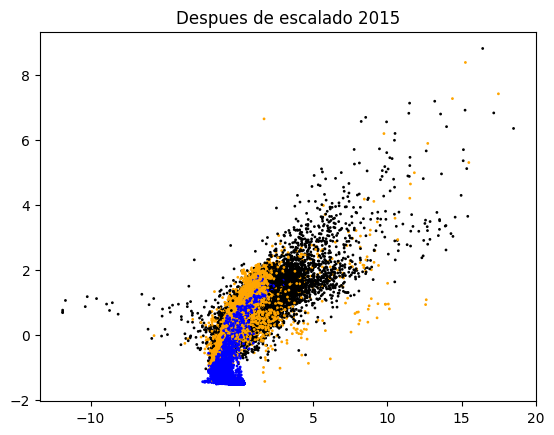

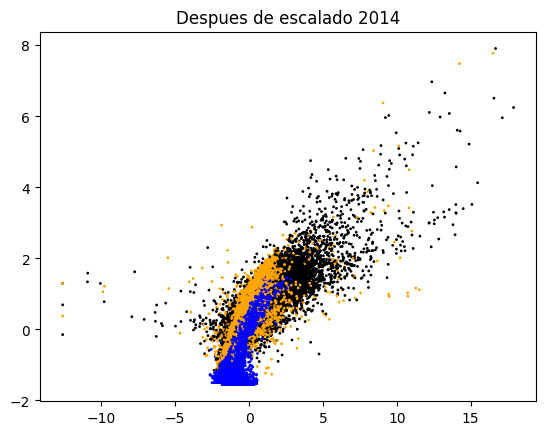

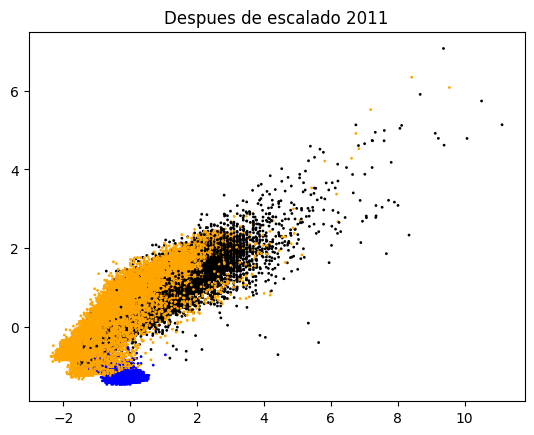

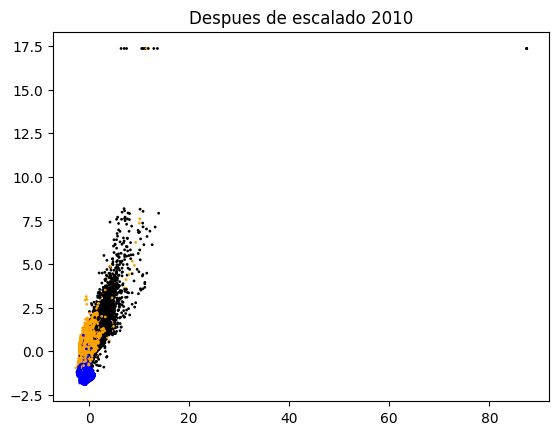

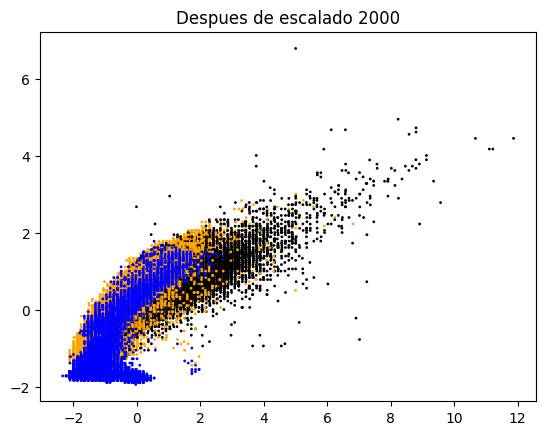

In [45]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(0,150930)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2020 = scale.fit_transform(x_features_2020)
x_features_2011 = scale.fit_transform(x_features_2011)
x_features_2010 = scale.fit_transform(x_features_2010)
x_features_2000 = scale.fit_transform(x_features_2000)

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2011[rango,0], x_features_2011[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2011')
plt.show()

plt.scatter(x_features_2010[rango,0], x_features_2010[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2010')
plt.show()

plt.scatter(x_features_2000[rango,0], x_features_2000[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2000')
plt.show()

In [46]:
print(x_features_2015)
print(y_labels_2015)

[[-0.48429557 -0.86293877 -0.57796715 -0.55157286  0.01817654  0.5957561 ]
 [-0.17890692 -0.68777945 -0.35523127 -0.45538961  0.22666374  0.94161626]
 [ 0.18705468 -0.209077    0.09455151 -0.20773213  0.51085016  1.25362063]
 ...
 [-1.85854448 -1.77058251 -1.89210884  1.71852464 -0.88241774 -1.14715342]
 [-1.79292378 -1.67603629 -1.83606562  1.9641663  -0.85500507 -1.12491481]
 [-1.7866141  -1.6979312  -1.82600658  1.63414832 -0.86707671 -1.13254896]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


Subdividir datos de entrenamiento y control (2015)

In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.2, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(120672, 6)
(120672, 1)
(30169, 6)
(30169, 1)
[[ 0.48234783  0.3353102   0.38985617  0.35813639  0.67205679  0.75773283]
 [-0.4022697  -0.49371089 -0.23236728  0.2106938   0.20352644  0.22168277]
 [ 0.70823448  0.7990843   1.19889037  0.99196673  1.55655556  1.40829514]
 ...
 [ 2.78790592  2.33670446  2.02516864  0.60665778  0.74624705  1.190224  ]
 [ 0.14667271  0.38308092  0.30722835  1.58058519  1.04351106  0.70362995]
 [-0.45905684 -0.86691966 -0.75615585  0.01861528 -0.17874201 -0.21611911]]
[[0]
 [0]
 [0]
 ...
 [2]
 [0]
 [2]]
(120672, 1, 6) (30169, 1, 6)


Continuar entrenamiento de la red neuronal (ANN) simple pre-entrenada

In [12]:
from tensorflow import keras
from keras.models import load_model

#print(keras.__version__)

## Cargar un modelo preentrenado
#model = load_model('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')
model = load_model('/content/drive/MyDrive/Colab Data/GDL_2015_model_ANN_2hl_3class.tensorflow')

print(model.summary())

# Continuar entrenamiento del modelo con datos adicionales
model.fit(xTrain, yTrain, epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
3771/3771 [==============================] - 17s 4ms/step - loss: 0.2202 - accuracy: 0.9311
Epoch 2/10
3771/3771 [============================

In [13]:
model.save('/content/drive/MyDrive/Colab Data/OCT_2015_model_ANN_2hl_3class_posentrenado.tensorflow')

In [14]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

943/943 [==============================] - 1s 1ms/step


In [15]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[18130    36   429]
 [  348  7478    13]
 [  980     3  2752]]

Exactitud (accuracy): 0.940,

Kappa de Cohen: 0.886,

Clase 1. Selectividad (precision): 0.932, especificidad (recall): 0.975, f1: 0.953

Clase 2. Selectividad (precision): 0.995, especificidad (recall): 0.954, f1: 0.974

Clase 3. Selectividad (precision): 0.862, especificidad (recall): 0.737, f1: 0.794


Predicción para datos de 2015

In [16]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

4714/4714 [==============================] - 8s 2ms/step
[[8.7816197e-01 3.4343445e-04 1.2149459e-01]
 [8.4441310e-01 1.1393555e-03 1.5444748e-01]
 [5.0934744e-01 1.0507045e-03 4.8960185e-01]
 ...
 [5.8213943e-03 9.9377185e-01 4.0681157e-04]
 [3.5090107e-03 9.9620807e-01 2.8284648e-04]
 [5.4083471e-03 9.9419820e-01 3.9348044e-04]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

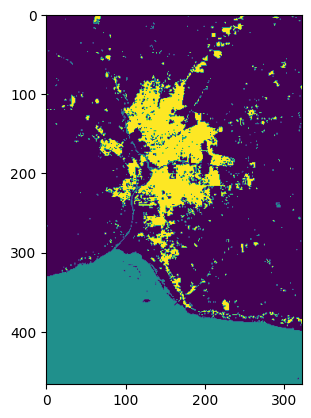

In [17]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

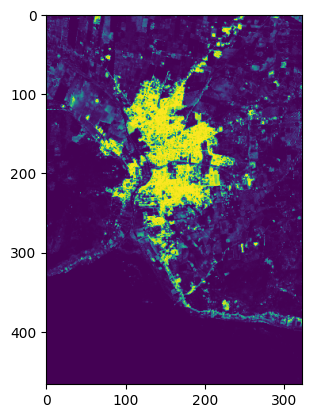

In [18]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [19]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

4714/4714 [==============================] - 18s 4ms/step
[[8.9867973e-01 3.9514368e-03 9.7368844e-02]
 [9.1585553e-01 4.2785467e-03 7.9865918e-02]
 [9.6338636e-01 3.4772735e-03 3.3136398e-02]
 ...
 [7.5461960e-04 9.9919432e-01 5.1111489e-05]
 [6.7654636e-04 9.9927640e-01 4.7080277e-05]
 [7.0664485e-04 9.9924076e-01 5.2613512e-05]]


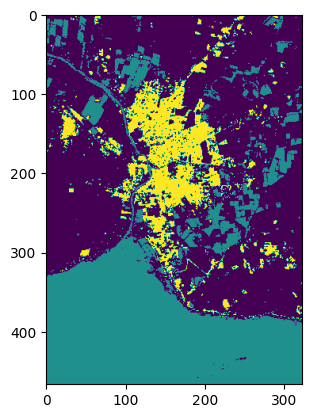

In [20]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

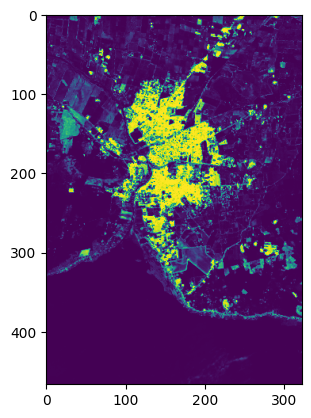

In [21]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [22]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

4714/4714 [==============================] - 9s 2ms/step
[[9.72268820e-01 8.85169604e-04 2.68460456e-02]
 [9.58514154e-01 1.17590837e-03 4.03100066e-02]
 [9.54029799e-01 7.26350816e-04 4.52438630e-02]
 ...
 [3.04468960e-01 5.89855969e-01 1.05675094e-01]
 [6.45047799e-02 9.25897002e-01 9.59816575e-03]
 [2.46159762e-01 6.89211726e-01 6.46285415e-02]]


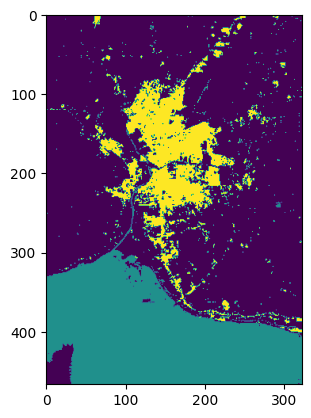

In [23]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

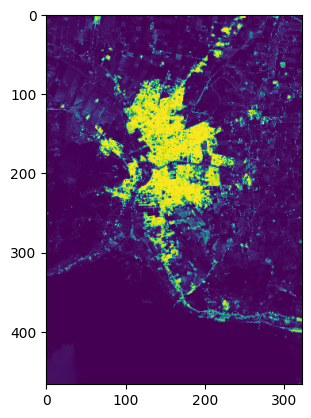

In [47]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [26]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/OCT_2014_prediction_class.npy', predicted_2014_class_re)
np.save('/content/drive/MyDrive/Colab Data/OCT_2015_prediction_class.npy', predicted_2015_class_re)
np.save('/content/drive/MyDrive/Colab Data/OCT_2020_prediction_class.npy', predicted_2020_class_re)
np.save('/content/drive/MyDrive/Colab Data/OCT_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/OCT_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/OCT_2020_prediction_urbano_float.npy', prediction_2020_urbano)

Preparar datos binarios 2014 para uso como target en modelo L5

In [27]:
x_features_2011_n = x_features_2011
x_features_2011_n = x_features_2011_n.reshape((x_features_2011_n.shape[0], 1, x_features_2011_n.shape[1]))

y_target_2011_n = predicted_2014_class.reshape(x_features_2014_n.shape[0], 1)

print(x_features_2011_n.shape, y_target_2011_n.shape)

(150841, 1, 6) (150841, 1)


Posentrenar modelo L5

In [48]:
## Cargar un modelo preentrenado
model1 = load_model('/content/drive/MyDrive/Colab Data/GDL_2011_model_ANN_2hl_3class.tensorflow')

print(model1.summary())

# Posentrenar con datos 2011
model1.fit(x_features_2011_n, y_target_2011_n, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 20)                140       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
4714/4714 [==============================] - 13s 3ms/step - loss: 0.1948 - accuracy: 0.9359
Epoch 2/10
4714/4714 [==========================

In [49]:
model.save('/content/drive/MyDrive/Colab Data/OCT_2011_model_ANN_2hl_3class_posentrenado.tensorflow')

Prediccion 2011

In [50]:
predicted_2011 = model1.predict(x_features_2011_n)
print(predicted_2011)

4714/4714 [==============================] - 8s 2ms/step
[[9.9688131e-01 1.1888760e-08 3.1186086e-03]
 [9.9786675e-01 7.5532919e-10 2.1331992e-03]
 [9.9615628e-01 1.5582189e-09 3.8437287e-03]
 ...
 [9.6592065e-03 9.9000019e-01 3.4056336e-04]
 [3.1596072e-02 9.6788251e-01 5.2142108e-04]
 [8.4584318e-03 9.9128461e-01 2.5701249e-04]]


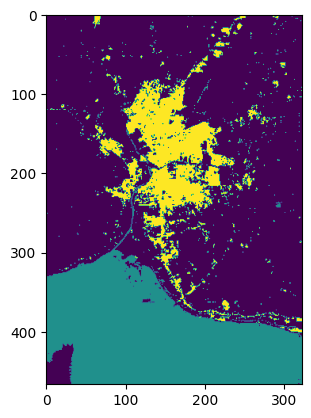

In [51]:
predicted_2011_class = predicted_2011.argmax(axis=-1)
predicted_2011_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2011_class_re[:,:])
plt.show()

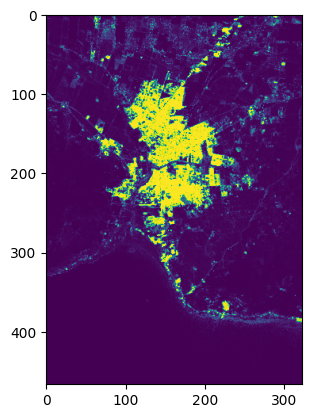

In [52]:
prediction_2011_urbano = np.reshape(predicted_2011[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2011 = (prediction_2011_urbano).astype('float')
plt.imshow(B_img_pred_2011[:,:])
plt.show()

Prediccion 2010

In [53]:
x_features_2010_n = x_features_2010
x_features_2010_n = x_features_2010_n.reshape((x_features_2010_n.shape[0], 1, x_features_2010_n.shape[1]))

predicted_2010 = model1.predict(x_features_2010_n)
print(predicted_2010)

4714/4714 [==============================] - 9s 2ms/step
[[8.6667448e-01 3.1139888e-04 1.3301413e-01]
 [9.9200076e-01 1.1207704e-05 7.9881027e-03]
 [9.9308562e-01 1.0554491e-05 6.9038244e-03]
 ...
 [6.1228961e-01 3.8767985e-01 3.0554085e-05]
 [3.1532606e-01 6.8466908e-01 5.0027170e-06]
 [6.5050900e-01 3.4945652e-01 3.4541350e-05]]


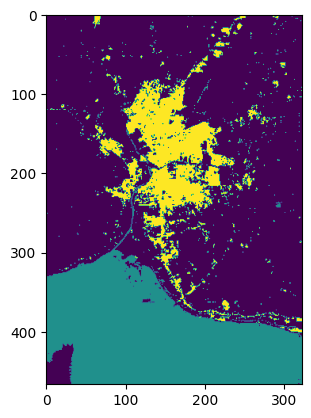

In [54]:
predicted_2010_class = predicted_2010.argmax(axis=-1)
predicted_2010_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2010_class_re[:,:])
plt.show()

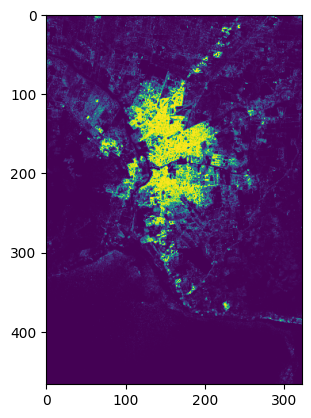

In [55]:
prediction_2010_urbano = np.reshape(predicted_2010[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2010 = (prediction_2010_urbano).astype('float')
plt.imshow(B_img_pred_2010[:,:])
plt.show()

Prediccion 2000

In [56]:
x_features_2000_n = x_features_2000
x_features_2000_n = x_features_2000_n.reshape((x_features_2000_n.shape[0], 1, x_features_2000_n.shape[1]))

predicted_2000 = model1.predict(x_features_2000_n)
print(predicted_2000)

4714/4714 [==============================] - 7s 1ms/step
[[9.9953884e-01 1.1622422e-11 4.6117773e-04]
 [9.9925458e-01 2.8826179e-11 7.4548181e-04]
 [9.9965346e-01 7.0389705e-12 3.4649912e-04]
 ...
 [9.9098396e-01 5.7115383e-05 8.9590242e-03]
 [9.7638768e-01 1.7359739e-04 2.3438722e-02]
 [9.9015909e-01 8.4488682e-05 9.7564366e-03]]


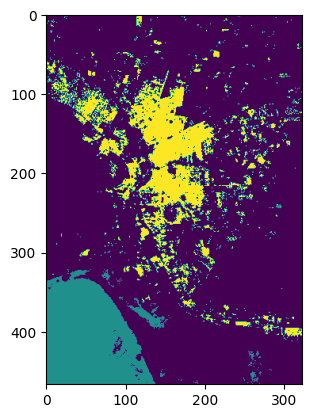

In [57]:
predicted_2000_class = predicted_2000.argmax(axis=-1)
predicted_2000_class_re = np.reshape(predicted_2000_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2000_class_re[:,:])
plt.show()

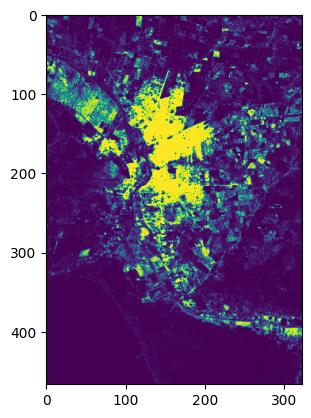

In [58]:
prediction_2000_urbano = np.reshape(predicted_2000[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2000 = (prediction_2000_urbano).astype('float')
plt.imshow(B_img_pred_2000[:,:])
plt.show()

In [59]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/OCT_2011_prediction_class.npy', predicted_2011_class_re)
np.save('/content/drive/MyDrive/Colab Data/OCT_2010_prediction_class.npy', predicted_2010_class_re)
np.save('/content/drive/MyDrive/Colab Data/OCT_2000_prediction_class.npy', predicted_2000_class_re)
np.save('/content/drive/MyDrive/Colab Data/OCT_2011_prediction_urbano_float.npy', prediction_2011_urbano)
np.save('/content/drive/MyDrive/Colab Data/OCT_2010_prediction_urbano_float.npy', prediction_2010_urbano)
np.save('/content/drive/MyDrive/Colab Data/OCT_2000_prediction_urbano_float.npy', prediction_2000_urbano)